### Входные данные


В качестве данных выступает набор данных с квалфикационного тура VkCup. Данные содержат статьи различных сообществ с разной тематикой. Цель заключается в том, чтобы определить тематику каждого сообщества по её статьям. 

Тренировочный набор данных состоит из трех столбцов:
1. oid - уникальный ID сообщества
2. category - категория сообщества
3. text - текст статьи


In [3]:
from sklearn.metrics import accuracy_score, precision_score, \
 recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import WordPunctTokenizer
from pymystem3 import Mystem
import pymorphy2

import pandas as pd
import numpy as np
import random
import re
import nltk
import string

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [5]:
tokenizer = WordPunctTokenizer()
lemmatizer = pymorphy2.MorphAnalyzer()
stopwords = nltk.corpus.stopwords.words("russian")

In [6]:
train_path = "path/to/train.csv"
test_path = "path/to/test.csv"

#### Загрузка и предобработка данных

In [7]:
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [8]:
df["category"] = df["category"].astype("category")
df["category_code"] = df["category"].cat.codes
idx2class = {i:class_name for i, class_name in enumerate(df["category"].cat.categories)}

df_oid = df.pivot_table(values="category_code", index=["oid"]).reset_index()

Перед подачей в модель статьи нужно предобработать, для этого в начале удалим все стоп слова, знаки пунктуации, цифры и слова с длиной меньшей, чем 2.

In [9]:
def preprocess_sents(sent, tokenizer=tokenizer):
    tokens = []
    sent_clean = re.sub("tokenoid|token|\d", "", sent).strip()
    for word in tokenizer.tokenize(sent_clean.lower()):
        if (word not in stopwords) and (word not in string.punctuation) and len(word) > 2:
            tokens.append(word)

    return " ".join(tokens)

In [10]:
df["clean_text"] = df["text"].apply(preprocess_sents)
df_test["clean_text"] = df_test["text"].apply(preprocess_sents)

Далее произведем лемматизацию слов с помощью PyMystem3

In [11]:
def pymorphy_lemmatize(sent, lemmatizer=lemmatizer):
    lemmatized_tokens = []
    for token in tokenizer.tokenize(sent):
        info = lemmatizer.parse(token)[0]
        lemmatized_tokens.append(info.normal_form)
    return " ".join(lemmatized_tokens)

df["lemmatized_text"] = df["clean_text"].apply(pymorphy_lemmatize)
df_test["lemmatized_text"] = df_test["clean_text"].apply(pymorphy_lemmatize)

Разделяем выборку на train и val по oid в соотношении 80:20

In [12]:
oid_train, oid_val, oid_labels_train, oid_labels_val = train_test_split(df_oid["oid"], 
                                                                        df_oid["category_code"], 
                                                                        test_size=0.2, 
                                                                        random_state=SEED)

In [13]:
def get_data_by_oids(df, df_oids):
    sents = []
    labels = []
    oids = []
    for oid in df_oids:
        label = df[df["oid"] == oid]["category_code"].iloc[0]
        for sent in df[df["oid"] == oid]["lemmatized_text"]:
            sents.append(sent)
            labels.append(label)
            oids.append(oid)
    return sents, labels, oids

In [14]:
train_sents, train_labels, train_oids = get_data_by_oids(df, oid_train)
val_sents, val_labels, val_oids = get_data_by_oids(df, oid_val)

all_train_sents = df["lemmatized_text"]
all_train_labels = df["category_code"]
all_train_oids = df["oid"] 

test_sents = df_test["lemmatized_text"]
test_oids = df_test["oid"]

Определяем функцию для вывода метрик

In [15]:
def print_metrics(y_test, y_pred):
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Macro precision: ", precision_score(y_test, y_pred, average="macro"))
    print("Micro precision: ", precision_score(y_test, y_pred, average="micro"))
    print("Macro recall: ", recall_score(y_test, y_pred, average="macro"))
    print("Micro recall: ", recall_score(y_test, y_pred, average="micro"))
    print("Macro f1-score: ", f1_score(y_test, y_pred, average="macro"))
    print("Micro f1-score: ", f1_score(y_test, y_pred, average="micro"))


#### Классификация с помощью Bag of words и TF-IDF

Для классификации по признакам из BOW и TF-IDF будем использовать модель случайного леса

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

Bag of words - способ представления текста в виде вектора, состоящих из количества вхождения каждого слова в текст.

In [17]:
count_vectorizer = CountVectorizer()
train_vectorize = count_vectorizer.fit_transform(train_sents)
val_vectorize = count_vectorizer.transform(val_sents)
print(train_vectorize.shape)

(30990, 61863)


In [18]:
rf = RandomForestClassifier(random_state=SEED, bootstrap=False)
rf.fit(train_vectorize, train_labels)

pred_rf_bow = rf.predict(val_vectorize)
print_metrics(val_labels, pred_rf_bow)

Accuracy:  0.8140645161290323
Macro precision:  0.8189358640592937
Micro precision:  0.8140645161290323
Macro recall:  0.8176135705771427
Micro recall:  0.8140645161290323
Macro f1-score:  0.8173082422264675
Micro f1-score:  0.8140645161290323


In [19]:
logreg = LogisticRegressionCV(random_state=SEED, multi_class="multinomial", solver="newton-cg")
logreg.fit(train_vectorize, train_labels)

pred_logreg_bow = logreg.predict(val_vectorize)
print_metrics(val_labels, pred_logreg_bow)

Accuracy:  0.8238709677419355
Macro precision:  0.8319634702770892
Micro precision:  0.8238709677419355
Macro recall:  0.8275898670979198
Micro recall:  0.8238709677419355
Macro f1-score:  0.828181436190573
Micro f1-score:  0.8238709677419355


TF-IDF - ещё один метод для векторизации предложения. Проблема BOW в том, что он не учитвает полезность слова. TF-IDF решает эту проблему. Данный метод считает для каждого слова частоту вхождения слова $w$ в документ и умножает на обратную частоту вхождения ($log(\frac{количество \space документов}{количество \space документов, \space со \space  словом \space w })$). Таким образом, если слово часто встрачется в одном документе и практически не встречается в остальных, то такое слово будет иметь большее значение, чем, например, слово, которое встречается часто и в этом документе, и в остальных.

In [20]:
tfidf_vectorizer = TfidfVectorizer()
train_vectorize = tfidf_vectorizer.fit_transform(train_sents)
val_vectorize = tfidf_vectorizer.transform(val_sents)
print(train_vectorize.shape)

(30990, 61863)


In [21]:
rf = RandomForestClassifier(random_state=SEED, bootstrap=False)
rf.fit(train_vectorize, train_labels)

pred_rf_tfidf = rf.predict(val_vectorize)
print_metrics(val_labels, pred_rf_tfidf)

Accuracy:  0.8140645161290323
Macro precision:  0.8202056371562398
Micro precision:  0.8140645161290323
Macro recall:  0.8177364122553967
Micro recall:  0.8140645161290323
Macro f1-score:  0.8178599896234205
Micro f1-score:  0.8140645161290323


В целом оба подхода к векторизации дали одинаковое качество классификации

#### Navec

Далее попробуем использовать предобученные эмбеддинги слов, для этого используем модель navec.

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [25]:
from navec import Navec

In [26]:
navec = Navec.load("navec_hudlit_v1_12B_500K_300d_100q.tar")

Будем вычислять вектор предложения как усредненную сумму векторов всех слов в предложении

In [27]:
def sentence2vector(sent, embedding, emb_dim, tokenizer=tokenizer):
    tokens = tokenizer.tokenize(sent)
    token_sum = np.zeros(emb_dim)
    token_count = 0

    for token in tokens:
        if token in embedding.vocab:
            token_sum += embedding[token]
            token_count += 0

    if token_count == 0:
        return token_sum
    
    return token_sum / token_count

In [28]:
train_vectorize = [sentence2vector(sent, navec, 300) for sent in train_sents]
val_vectorize = [sentence2vector(sent, navec, 300) for sent in val_sents] 

Обучим случайный лес на полученных векторах предложений

In [29]:
rf = RandomForestClassifier(random_state=SEED)
rf.fit(train_vectorize, train_labels)

pred_rf_navec = rf.predict(val_vectorize)
print_metrics(val_labels, pred_rf_navec)

Accuracy:  0.5678709677419355
Macro precision:  0.571717549229285
Micro precision:  0.5678709677419355
Macro recall:  0.570062298060998
Micro recall:  0.5678709677419355
Macro f1-score:  0.5657887836295997
Micro f1-score:  0.5678709677419355


Модель, обученная на таких представлениях предложений, дала значительно худшее качество, чем обученная на TF-IDF и BOW. Скорее всего это произошлол из-за того, что navec может не знать многие слова из набора данных, которые являются важными для понимания смысла. 

#### Word2Vec

In [30]:
from gensim.models import Word2Vec

In [31]:
tokenized_sents = [tokenizer.tokenize(sent) for sent in train_sents]

In [32]:
w2v_embeddings = Word2Vec(tokenized_sents,
                          size=300,
                          min_count=1,
                          window=15,).wv

In [33]:
train_vectorize = [sentence2vector(sent, w2v_embeddings, 300) for sent in train_sents]
val_vectorize = [sentence2vector(sent, w2v_embeddings, 300) for sent in val_sents]

In [34]:
rf = RandomForestClassifier(random_state=SEED, bootstrap=False)
rf.fit(train_vectorize, train_labels)

pred_rf_w2v = rf.predict(val_vectorize)
print_metrics(val_labels, pred_rf_w2v)

Accuracy:  0.6565161290322581
Macro precision:  0.665963416591041
Micro precision:  0.6565161290322581
Macro recall:  0.6618989094742673
Micro recall:  0.6565161290322581
Macro f1-score:  0.6600183693441273
Micro f1-score:  0.6565161290322581


#### Классификация с помощью нейросетей

Попробуем произвести классификацию с помощью нейросетей

In [36]:
from tqdm.notebook import tqdm
from torchdata.datapipes.iter import IterableWrapper
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 
import seaborn as sns
import torch.nn as nn
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Создаем словарь на обучающей выборке

In [38]:
def text_iterator(text):
    for row in text:
        yield tokenizer.tokenize(row)

In [39]:
text_vocab = build_vocab_from_iterator(text_iterator(train_sents), 
                                       specials=["<unk>", "<pad>"],
                                       min_freq=5)
text_vocab.set_default_index(text_vocab["<unk>"])
print(len(text_vocab))

18491


Определяем функции для предобработки данных и сортировки

In [40]:
def preprocess_pipe(row, tokenizer=tokenizer, vocab=text_vocab):
    tokens = vocab(tokenizer.tokenize(row[0]))
    return (tokens, *row[1:])

def sort_keys(data):
    return sorted(data, key=lambda x: len(x[0]))

Создаем датасет, для этого в начале оборачиваем наши данные в datapipe, в которых выполняем предобработку и разделение выборки на батчи так, чтобы в каждом батче были предложения с практически равной длиной. 

Далее при создании набора данных нам нужно будет привести каждое предложение из батча к одинаковой длине, заполнив нулями (такая операция также называется padding). Если в батче будут предложения с большой разницей в длине, то придется тратить очень много памяти на приведение их к одинаковой длине. Поэтому пред разбиением на батчи данные предварительно сортируются. 

In [41]:
train_dp = IterableWrapper(zip(train_sents, train_labels, train_oids))
val_dp = IterableWrapper(zip(val_sents, val_labels, val_oids))
all_train_dp = IterableWrapper(zip(all_train_sents, all_train_labels, all_train_oids))

train_dp_prep = train_dp.map(preprocess_pipe)
val_dp_prep = val_dp.map(preprocess_pipe)
all_train_prep = all_train_dp.map(preprocess_pipe)

train_dp_bucket = train_dp_prep.bucketbatch(128, sort_key=sort_keys)
val_dp_bucket = val_dp_prep.bucketbatch(128, sort_key=sort_keys)
all_train_bucket = all_train_prep.bucketbatch(128, sort_key=sort_keys)

train_dataset = to_map_style_dataset(train_dp_bucket)
val_dataset = to_map_style_dataset(val_dp_bucket)
all_train_dataset = to_map_style_dataset(all_train_bucket)

Опредеяем функции для предобработки батчей и функции приведения батчей к одному размеру

In [85]:
def batch_pad(batch, vocab=text_vocab):
    pad_batch = []
    max_len = max([len(sent) for sent, _, _ in batch])
    for sent, label, oid in batch:
        sent_pad = [vocab["<pad>"]]*(max_len-len(sent))
        pad_batch.append([sent+sent_pad, label, oid])
    return pad_batch

def batch_preprocess(batch):
    sent_list = []
    label_list = []
    oid_list = []
    batch_padded = batch_pad(batch)
    for sent, label, oid in batch_padded:
        sent_list.append(sent)
        label_list.append(label)
        oid_list.append(oid)
    sent_tensor = torch.tensor(sent_list, dtype=torch.int64) # .permute((1,0)).contiguous()
    label_tensor = torch.tensor(label_list, dtype=torch.int64)
    oid_tensor = torch.tensor(oid_list, dtype=torch.int64)

    return (sent_tensor, label_tensor, oid_tensor)

Создаем загрузчики данных, для train выборки также ставим параметр shuffle=True

In [86]:
train_dataloader = DataLoader(train_dataset, batch_size=None, collate_fn=batch_preprocess, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=None, collate_fn=batch_preprocess)
all_train_dataloader = DataLoader(all_train_dataset, batch_size=None, collate_fn=batch_preprocess)

Определяем функции для обучения и оценки модели

In [116]:
def train_step(model,
                dataloader,
                criterion,
                optimizer):
    mean_accuracy = 0.0
    mean_loss = 0.0
    count_sents = 0

    model.train()
    for batch in tqdm(dataloader):
        sents, labels, _ = batch
        sents = sents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(sents)

        pred_labels = pred.argmax(axis=1)
        mean_accuracy += (pred_labels == labels).sum().item()

        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        mean_loss += loss.detach()

        count_sents += sents.shape[0]
    
    mean_accuracy /= count_sents
    mean_loss /= count_sents

    return mean_accuracy, mean_loss

def val_step(model,
                dataloader,
                criterion):
    mean_accuracy = 0.0
    mean_loss = 0.0
    count_sents = 0

    model.eval()
    for batch in tqdm(dataloader):
        sents, labels, _ = batch
        sents = sents.to(device)
        labels = labels.to(device)

        pred = model(sents)

        pred_labels = pred.argmax(axis=1)
        mean_accuracy += (pred_labels == labels).sum().item()

        loss = criterion(pred, labels)
        mean_loss += loss.detach()

        count_sents += sents.shape[0]
    
    mean_accuracy /= count_sents
    mean_loss /= count_sents
    
    return mean_accuracy, mean_loss

def train(model,
          train_dataloader,
          criterion,
          optimizer,
          save_dir,
          val_dataloader=None,
          scheduler=None,
          epochs=10):
    
    history = {
        "train_loss":[],
        "train_acc":[],
        "val_loss":[],
        "val_acc":[]
    }
    best_loss = 999999

    for epoch in tqdm(range(epochs)):
        train_acc, train_loss = train_step(model, 
                                        train_dataloader, 
                                        criterion, 
                                        optimizer)
        
        history["train_loss"].append(train_loss.item())
        history["train_acc"].append(train_acc)
        print(f"Epoch: {epoch}, Train_loss: {train_loss}, Train_acc: {train_acc}")

        if not val_dataloader is None:
            val_acc, val_loss = val_step(model,
                                        val_dataloader,
                                        criterion)
            history["val_loss"].append(val_loss.item())
            history["val_acc"].append(val_acc)
            print(f"Epoch: {epoch}, Val_loss: {val_loss}, Val_acc: {val_acc}")

            if best_loss > val_loss.item():
                print("New best result!")
                best_loss = val_loss.item()
                torch.save(model.state_dict(), save_dir)
        else:
            if best_loss > train_loss.item():
                print("New best result!")
                best_loss = train_loss.item()
                torch.save(model.state_dict(), save_dir)

    return history

def eval_model(model, dataloader):
    pred_labels = []
    true_labels = []
    
    model.eval()
    for batch in dataloader:
        sents, labels, _ = batch
        sents = sents.to(device)

        pred = model(sents)

        pred_labels.extend(pred.argmax(axis=1).tolist())
        true_labels.extend(labels.tolist())
    
    print_metrics(true_labels, pred_labels)
    return pred_labels

def eval_by_oids(model, dataloader):
    model.eval()
    oids_dict = {}
    for batch in dataloader: 
        sents, labels, oids = batch 
        sents = sents.to(device)
        labels = labels.tolist()
        oids = oids.tolist()

        pred = model(sents).detach().cpu().tolist()
        for i, oid in enumerate(oids):
            if oid not in oids_dict.keys():
                oids_dict[oid] = {
                    "pred":np.array(pred[i]),
                    "label":labels[i],
                    "count":1
                }
                continue
            oids_dict[oid]["pred"] += pred[i]
            oids_dict[oid]["count"] += 1
    
    metric = 0
    for oid in oids_dict.keys():
        pred = oids_dict[oid]["pred"] / oids_dict[oid]["count"]
        pred_label = np.argmax(pred)
        if pred_label == oids_dict[oid]["label"]:
            metric += 1
        else:
            metric -= 1
    metric /= len(oids_dict.keys())
    return metric

def generate_test_answer(model, test_data):
    model.eval()
    oids_dict = {}
    for sent, oid in test_data:
        sent_tokens = [text_vocab[token] for token in tokenizer.tokenize(sent)]
        sent_tensor = torch.tensor(sent_tokens, dtype=torch.int64).to(device)
        sent_tensor = sent_tensor.unsqueeze(1)
        pred = model(sent_tensor).cpu().detach().tolist()[0]

        if oid not in oids_dict.keys():
            oids_dict[oid] = {"pred":np.array(pred), "count":1}
            continue
        oids_dict[oid]["pred"] += pred
        oids_dict[oid]["count"] += 1

    result = []
    for oid in oids_dict.keys():
        pred_avg = oids_dict[oid]["pred"] / oids_dict[oid]["count"] 
        pred_label = np.argmax(pred_avg)
        result.append([oid, idx2class[pred_label]])
    return pd.DataFrame(result, columns=["oid", "category"])

def draw_history(history):
    figure = plt.figure(figsize=(10, 10))
    gs = figure.add_gridspec(2, 1)

    figure.add_subplot(gs[0, 0])
    plt.plot(list(range(len(history["train_acc"]))), 
             history["train_acc"], 
             label="train_acc")
    plt.plot(list(range(len(history["val_acc"]))), 
             history["val_acc"], 
             label="val_acc")
    plt.legend()

    figure.add_subplot(gs[1, 0])
    plt.plot(list(range(len(history["train_loss"]))), 
             history["train_loss"], 
             label="train_loss")
    plt.plot(list(range(len(history["val_loss"]))), 
             history["val_loss"], 
             label="val_loss")
    plt.legend()

##### EmbeddingBag

EmbeddingBagModel - модель, в которой все обученные эмбеддинги слов суммируются и усредняются (тот же самый подход, который был с исопльзованием navec). Для этого в PyTorch есть слой EmbeddingBag, в котором содержаться обучаемые эмбеддинги и который находит усредненную сумму всех эмбеддингов слов в предложении. На выходе этого слоя идет вектор размерности 512, который далее подается в полносвязную сеть с обычными линейными слоями, слоями нормализации, Dropout и функцией активации ReLU.

In [121]:
class EmbeddingBagModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.emb_bag = nn.EmbeddingBag(input_dim, 512)

        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x_input):
        x = self.dropout1(self.emb_bag(x_input))
        x = self.dropout2(self.relu1(self.bn1(self.fc1(x))))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)

        return x

В качестве оптимизатора был выбран Adam с шагом обучения 0.001, в качестве функции потерь CrossEnthropy. Всего модель имеет 9 211 917 параметров.

In [122]:
INPUT_DIM = len(text_vocab)
OUTPUT_DIM = 13
emb_bag_model = EmbeddingBagModel(INPUT_DIM, OUTPUT_DIM)
emb_bag_model.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(emb_bag_model.parameters(), lr)
print("Params: ", sum([param.numel() for param in emb_bag_model.parameters()]))

Params:  9633805


Обучим модель на 20 эпохах

In [ ]:
emb_bag_dir = "./emb_bag.pt"
history = train(emb_bag_model, 
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                criterion=criterion,
                optimizer=optimizer,
                save_dir=emb_bag_dir,
                epochs=20)

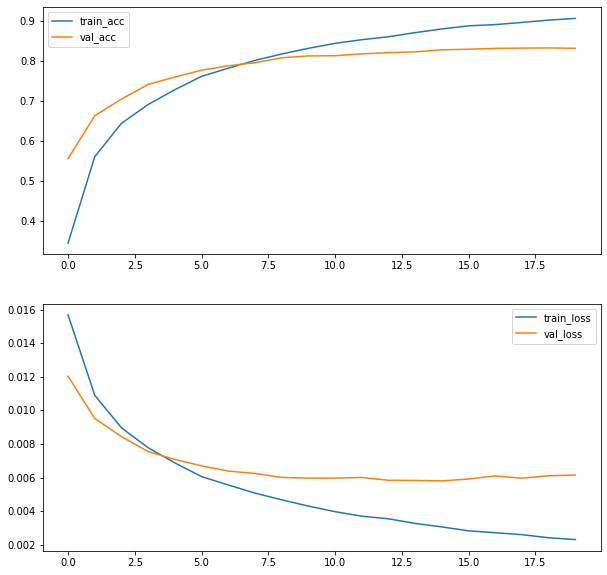

In [124]:
draw_history(history)

Загрузим веса модели, на которых было достингуто наименьшее значение функции потерь

In [ ]:
best_model = EmbeddingBagModel(INPUT_DIM, OUTPUT_DIM).to(device)
best_model.load_state_dict(torch.load(emb_bag_dir, map_location=torch.device(device)))

In [126]:
pred_bag = eval_model(best_model, val_dataloader)

Accuracy:  0.828516129032258
Macro precision:  0.8286332661754379
Micro precision:  0.828516129032258
Macro recall:  0.8326422430646586
Micro recall:  0.828516129032258
Macro f1-score:  0.8295079074354413
Micro f1-score:  0.828516129032258


In [127]:
eval_by_oids(best_model, val_dataloader)

0.9638709677419355

В целом мы получили результаты, которые намного выше, чем предыдущие методы

#### RNN (LSTM)

Вторая архитектура основана на рекуррентных блоках LSTM. В начале вычисляется эмбеддинг для каждого слова, после они подаются на вход двусторонней LSTM с двумя слоями и Dropout. Выходной вектор подается на линейный слой, с помощью которого прозводится классификация.

In [109]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, output_dim, bidirectional=True):
        super().__init__()
        self.bidirectional=True 
        self.n_layers=2
        self.emb = nn.Embedding(input_dim, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.rnn = nn.LSTM(512, 
                           128, 
                           bidirectional=bidirectional, 
                           num_layers=self.n_layers, 
                           dropout=0.5,
                           batch_first=True)
        self.fc1 = nn.Linear(128*self.n_layers*(1 + bidirectional), 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)

    
    def forward(self, x_input):
        x = self.dropout1(self.emb(x_input))
        output, (hidden, cell) = self.rnn(x)
        if self.bidirectional == True or self.n_layers > 1:
            hidden = hidden.permute((1,0,2)).reshape(x_input.shape[0], -1)

        x = self.dropout2(self.fc1(hidden))
        x = self.fc2(x)
        return x

Оптимизатор, функция потерь и шаг обучения выбраны такие же, как и при обучении EmbeddingBagModel. Модель имеет 6 139 025 параметров. 

In [110]:
INPUT_DIM = len(text_vocab)
OUTPUT_DIM = 13

rnn_model = RNNModel(INPUT_DIM, OUTPUT_DIM)
rnn_model.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr)
print("Params: ", sum([param.numel() for param in rnn_model.parameters()]))

Params:  10587405


Обучим модель на 20 эпохах

In [ ]:
rnn_dir = "./rnn.pt"
history = train(rnn_model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                criterion=criterion,
                optimizer=optimizer,
                save_dir=rnn_dir,
                epochs=20)

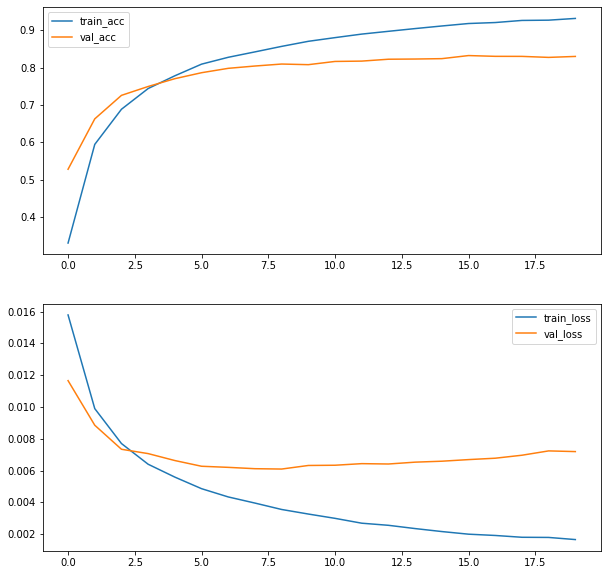

In [112]:
draw_history(history)

Загрузим веса модели, на которых было достигнуто наименьшее значение функции потерь и посчитаем метрики на val наборе

In [113]:
best_model = RNNModel(INPUT_DIM, OUTPUT_DIM).to(device)
best_model.load_state_dict(torch.load(rnn_dir, map_location=torch.device(device)))
pred_rnn = eval_model(best_model, val_dataloader)

Accuracy:  0.8099354838709677
Macro precision:  0.8146449382498488
Micro precision:  0.8099354838709677
Macro recall:  0.8145763624499287
Micro recall:  0.8099354838709677
Macro f1-score:  0.8122722159551092
Micro f1-score:  0.8099354838709677


In [117]:
eval_by_oids(best_model, val_dataloader)

0.9458064516129032

В результате мы получили значения, меньшие чем на модели EmbeddingBag. 